# Biodiversity Intactness Index Change in Phoenix, AZ

Author : Joshua Ferrer-Lozano
Date: 12/5/2025

You can access the full analysis of the project in this [Github repository](https://github.com/Awoo56709/Biodiversity-Intactness-Index-change-in-Phoenix-AZ)

## About
### Purpose
This notebook investigates changes in the Biodiversity Intactness Index (BII) in the Phoenix subdivision between 2017 and 2020. The goal is to understand how rapid urban expansion has affected biodiversity.

### Highlights
- Imported and explored BII raster datasets (2017, 2020) from the Microsoft Planetary Computer.  
- Clipped rasters to the Phoenix subdivision shapefile.  
- Calculated the percentage of area with BII ≥ 0.75 for both years.  
- Visualized areas of biodiversity loss between 2017 and 2020.  

### About the Data
- **BII Time Series (2017, 2020):** Global 100m projections of biodiversity intactness, accessed via Microsoft Planetary Computer STAC catalog.  
- **Phoenix Subdivision Shapefile:** Census County Subdivision shapefiles for Arizona, used to define the study area.  
- **Contextual Data:** Optional basemap tiles from `contextily` for geographic context.  



### References
- Levitt, Z., & Eng, J. (2021). *Where America’s developed areas are growing: ‘Way off into the horizon’.* The Washington Post. https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/  
- Gassert, F., Mazzarello, J., & Hyde, S. (2022). *Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].* https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf  
- Microsoft Planetary Computer, STAC Catalog. Biodiversity Intactness ('io-biodiversity'). [Dataset]. https://planetarycomputer.microsoft.com/dataset/io-biodiversity Accessed 6 December 2023.


# Import Libraries

In [12]:
# Load in Libraries

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patch

# geospatial libraries
import xarray as xr
import rioxarray as rio
from shapely.geometry import box

# Planetary Computer Access
import contextily as ctx
import planetary_computer

# Check python environment
import sys
print(sys.executable)

from pystac_client import Client




c:\Users\joshu\.conda\envs\eds220-env\python.exe


# Access Planetary Computer STAC Catalog: io-biodiversity collection

In [13]:
# Connect to the Planetary Computer STAC API
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Exploring catalog metadata
print('Title', catalog.title)


# Pull out the io_biodiversity collection
io_collection = catalog.get_child('io_biodiversity')
print(io_collection)


Title Microsoft Planetary Computer STAC API
None


# Define our parameters

In [14]:

# Temporal range of interest (2017–2020 drought period)
time_range = '2017-01-01/2020-01-01'

# Bounding box for Phoenix subdivision
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Get items from search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range)

# Retrieve items
items = search.item_collection()
print(len(items))

4


# Explore the search

In [19]:
# Get the io-biodiversity collection
io_collection = catalog.get_collection('io-biodiversity')

# Print the collection metadata
print("\nID:", io_collection.id)
print("Title:", io_collection.title)
print("Description:", io_collection.description)
print("Extent:", io_collection.extent)

# Convert items to a list
all_items = list(search.items())

# Print item IDs and properties
for item in all_items:
    print(item.id, item.properties)



ID: io-biodiversity
Title: Biodiversity Intactness
Description: Generated by [Impact Observatory](https://www.impactobservatory.com/), in collaboration with [Vizzuality](https://www.vizzuality.com/), these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020.

Maps depicting the intactness of global biodiversity have become a critical tool for spatial planning and management, monitoring the extent of biodiversity across Earth, and identifying critical remaining intact habitat. Yet, these maps are often years out of date by the time they are available to scientists and policy-makers. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the [PREDICTS database](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.2579) of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. The approach differs from previous work by modeling the relationship between obs

In [21]:
# Retrieve search items 
items = search.item_collection()
print(f"There is {len(items)} items in the search.")

There is 4 items in the search.


# Select 2017 and 2020 Raster

In [23]:


# Create a lookup table
lookup = {int(item.properties["start_datetime"][:4]): item for item in items} # year is available inside start_datetime not datetime 

# Store 2017 and 2020 raster
phoenix_2017 = lookup[2017]
phoenix_2020 = lookup[2020]

# Arizona Data

In [24]:
# Import Arizona Census Subdivision data

# display all columns when looking at dataframes
pd.set_option("display.max.columns", None)

arizona_fp = os.path.join('data','tl_2022_04_cousub','tl_2022_04_cousub.shp')
arizona = gpd.read_file(arizona_fp)

# preliminary exploration
arizona.head(5)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,None,None,None,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,None,None,None,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,None,None,None,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,Nogales,Nogales CCD,22,Z5,G4040,None,None,None,S,1762322938,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,None,None,None,S,1439530300,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


# Map the subdivision

In [7]:
# Select the Phoenix Subdivision
phoenix = arizona[arizona["NAME"] == "Phoenix"]

print(phoenix.crs)

EPSG:4269


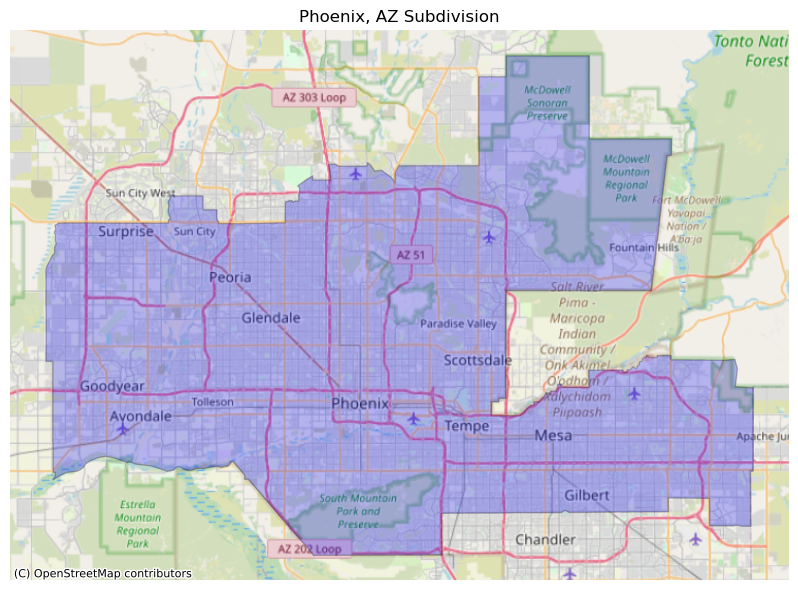

In [9]:
# Create map of Phoenix subdivision with basemap
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# plot Phenix subdivision polygon
phoenix.plot(ax=ax, facecolor='blue', edgecolor='black', linewidth=1, alpha=0.25)

# Add OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = phoenix.crs)

# Add title and remove axes
ax.set_title('Phoenix, AZ Subdivision')

# Remove axes
ax.axis('off')

# Display the map
plt.tight_layout()
plt.show()

In [28]:
# Select 2017 and 2020 rasters from search
item_2020 = items[0]
item_2017 = items[3]

# Extract 2017 and 2020 rasters using open_rasterio()
phoenix_2017 = rio.open_rasterio(item_2017.assets['data'].href)
phoenix_2020 = rio.open_rasterio(item_2020.assets['data'].href)

In [29]:
# Align Phoenix subdivision with raster CRS
phoneix = phoenix.to_crs(phoenix_2020.rio.crs)

# Clip rasters to Phoenix subdivision boundary
phoenix_2017_clip = phoenix_2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
phoenix_2020_clip = phoenix_2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)


In [31]:
# Identify area with biodiversity intactness index is > .75
phoenix_mask_2017 = phoenix_2017_clip >= .75
phoenix_mask_2020 = phoenix_2020_clip >= .75

In [32]:
# Calculate percentage of Phoenix area with BII > .75
pct_bii_2017 = (phoenix_mask_2017.sum() / phoenix_mask_2017.count()) * 100
pct_bii_2020 = (phoenix_mask_2020.sum() / phoenix_mask_2020.count()) * 100

In [34]:
# Identify areas that were greater than .75 in 2017 but dropped below .75 in 2020
bii_loss_mask = phoenix_mask_2017 & (~phoenix_mask_2020)

# Convert 0 values to NAs if the conditions are not met
bii_loss_mask = bii_loss_mask.where(bii_loss_mask!=0)

Text(0.5, 0.98, 'Biodiversity Intactness Index (BII)')

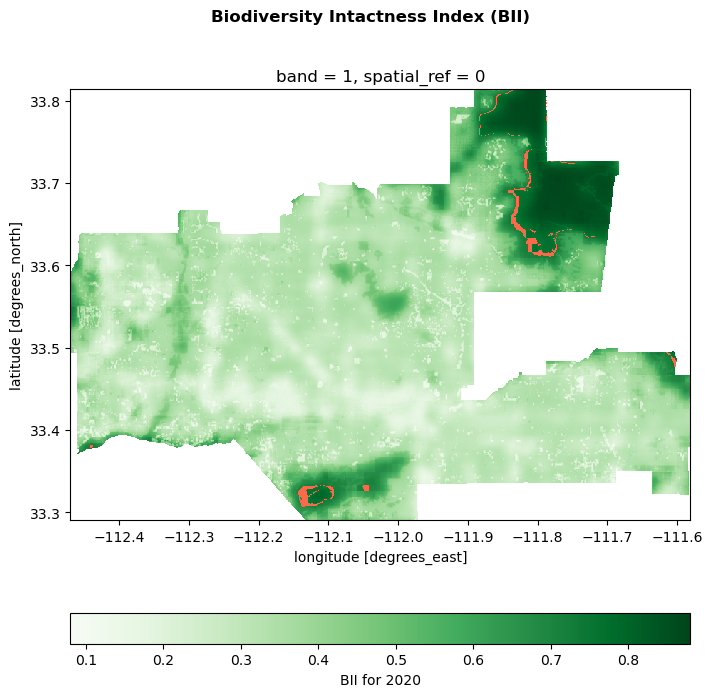

In [ ]:
# Plot mask visualization 
fig, ax = plt.subplots(figsize=(8, 8))

# Create choropleth map
phoenix_2020_clip.plot(cmap = 'Greens', cbar_kwargs={'location':'bottom', # Legend location
                                                 'label':'BII for 2020'})

# Plot the lost mask
bii_loss_mask.plot(ax=ax, cmap='Reds', add_colorbar = False)

# Add title
plt.suptitle('Biodiversity Intactness Index (BII)', fontsize=12, weight = 'bold')
